# GENERATIVE ADVERSARIAL NETWORK (GAN)

AJAY KUMAR GAUTAM ||204102323||IITG||SPML||

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, \
  BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import torch 

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using{} device'.format(device))

Usingcuda device


In [8]:
# Loading the dataset using keras 
data = tf.keras.datasets.mnist
# touple data 
(x_train, y_train), (x_test, y_test) = data.load_data()

# map inputs to (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
#print("x_train.shape:", x_train.shape)
# Flattening the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)
# Dimensionality of the latent space
lat_dim = 100

In [9]:
# Defining the Generator 
def gen(lat_dim):
    i_p = Input(shape=(lat_dim,))
    h_l = Dense(128, activation=LeakyReLU(alpha=0.2))(i_p)
    h_l = BatchNormalization(momentum=0.7)( h_l)
    h_l = Dense(256, activation=LeakyReLU(alpha=0.2))( h_l)
    h_l = BatchNormalization(momentum=0.7)( h_l)
    h_l = Dense(512, activation=LeakyReLU(alpha=0.2))( h_l)
    h_l = BatchNormalization(momentum=0.7)( h_l)
    h_l = Dense(1024, activation=LeakyReLU(alpha=0.2))( h_l)
    h_l = BatchNormalization(momentum=0.7)( h_l)
    h_l = Dense(D, activation='tanh')( h_l)

    model = Model(i_p, h_l)
    return model

In [10]:
# Defining the Discriminator
def disc(img_size):
    i_p = Input(shape=(img_size,))
    h_l = Dense(1024, activation=LeakyReLU(alpha=0.2))(i_p)
    h_l = Dense(512, activation=LeakyReLU(alpha=0.2))( h_l)
    h_l = Dense(256, activation=LeakyReLU(alpha=0.2))( h_l)
    h_l = Dense(1, activation='sigmoid')( h_l)
    model = Model(i_p,  h_l)
    return model

In [11]:
# Combinig the Discriminator and Generator for training
'''for building the discriminator and compile'''
discriminator = disc(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

'''for building the generator and compile'''
generator = gen(lat_dim)

# input to represent noise sample from latent space
p = Input(shape=(lat_dim,))

# To get the image passing the noise
im = generator(p)

discriminator.trainable = False # only generator will be trained

false_pred = discriminator(im)  #fake Pridiction

# Create the combined model object and compile the combined model
cmb_model = Model(p, false_pred)
cmb_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [12]:
'''Training the GAN'''
# Configuration 
batch_size = 256
epochs =60000    # here we training the discriminator and generator only for 60000epochs
sample_period = 200 # for every `sample period` steps generate and save some data


# Creating the  batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

#  losses
disc_losses = [] # Discriminator Loss
gen_losses = []  # Generator loss

# folder to store the generate the image 
if not os.path.exists('GAN_IMAGE'):
    
    os.makedirs('GAN_IMAGE')

In [13]:
# Defining a  function to generate a grid of random samples from the generator
def sam_img(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, lat_dim)
    imgs = generator.predict(noise)

  # Rescale images 0 - 1
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("GAN_IMAGE/%d.png" % epoch)     # sample image from the generator and save into a file
    plt.close()

In [ ]:
"""TRAINING"""
for epoch in range(epochs):
  # Selecting a random batch of images
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_img = x_train[idx]
  
  # Generation of  fake/false images
    noise = np.random.randn(batch_size, lat_dim)
    false_img = generator.predict(noise)
  
  # Training of discriminator
    disc_loss_real, disc_acc_real = discriminator.train_on_batch(real_img, ones)
    disc_loss_false, disc_acc_false = discriminator.train_on_batch(false_img, zeros)
    disc_loss = 0.5 * (disc_loss_real + disc_loss_false)
    disc_acc  = 0.5 * (disc_acc_real + disc_acc_false)
  
  # Training of Generator
    noise = np.random.randn(batch_size, lat_dim)
    gen_loss = cmb_model.train_on_batch(noise, ones)
  
    noise = np.random.randn(batch_size, lat_dim)
    gen_loss = cmb_model.train_on_batch(noise, ones)
  
  # losses
    disc_losses.append(disc_loss)
    gen_losses.append(gen_loss)
  
    if epoch % 100 == 0:
        
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {disc_loss:.2f}, \
          d_acc: {disc_acc:.2f}, g_loss: {gen_loss:.2f}")
  
    if epoch % sample_period == 0:
        sam_img(epoch)


epoch: 1/60000, d_loss: 0.42,           d_acc: 0.51, g_loss: 0.50
epoch: 101/60000, d_loss: 0.22,           d_acc: 0.91, g_loss: 2.58
epoch: 201/60000, d_loss: 0.47,           d_acc: 0.80, g_loss: 0.97
epoch: 301/60000, d_loss: 0.44,           d_acc: 0.82, g_loss: 1.62
epoch: 401/60000, d_loss: 0.52,           d_acc: 0.77, g_loss: 2.00
epoch: 501/60000, d_loss: 0.46,           d_acc: 0.80, g_loss: 2.34
epoch: 601/60000, d_loss: 0.41,           d_acc: 0.88, g_loss: 2.27
epoch: 701/60000, d_loss: 0.43,           d_acc: 0.82, g_loss: 2.38
epoch: 801/60000, d_loss: 0.53,           d_acc: 0.74, g_loss: 2.15
epoch: 901/60000, d_loss: 0.48,           d_acc: 0.80, g_loss: 2.04
epoch: 1001/60000, d_loss: 0.60,           d_acc: 0.67, g_loss: 1.74
epoch: 1101/60000, d_loss: 0.48,           d_acc: 0.77, g_loss: 1.71
epoch: 1201/60000, d_loss: 0.57,           d_acc: 0.69, g_loss: 1.66
epoch: 1301/60000, d_loss: 0.58,           d_acc: 0.68, g_loss: 1.59
epoch: 1401/60000, d_loss: 0.62,           d_a

epoch: 11901/60000, d_loss: 0.60,           d_acc: 0.67, g_loss: 1.09
epoch: 12001/60000, d_loss: 0.60,           d_acc: 0.67, g_loss: 1.09
epoch: 12101/60000, d_loss: 0.60,           d_acc: 0.65, g_loss: 1.08
epoch: 12201/60000, d_loss: 0.62,           d_acc: 0.63, g_loss: 1.08
epoch: 12301/60000, d_loss: 0.62,           d_acc: 0.66, g_loss: 1.02
epoch: 12401/60000, d_loss: 0.62,           d_acc: 0.64, g_loss: 1.09
epoch: 12501/60000, d_loss: 0.60,           d_acc: 0.68, g_loss: 1.09
epoch: 12601/60000, d_loss: 0.59,           d_acc: 0.66, g_loss: 1.07
epoch: 12701/60000, d_loss: 0.62,           d_acc: 0.66, g_loss: 1.15
epoch: 12801/60000, d_loss: 0.59,           d_acc: 0.66, g_loss: 1.05
epoch: 12901/60000, d_loss: 0.57,           d_acc: 0.70, g_loss: 1.11
epoch: 13001/60000, d_loss: 0.58,           d_acc: 0.68, g_loss: 1.13
epoch: 13101/60000, d_loss: 0.59,           d_acc: 0.68, g_loss: 1.08
epoch: 13201/60000, d_loss: 0.60,           d_acc: 0.67, g_loss: 1.09
epoch: 13301/60000, 

epoch: 23701/60000, d_loss: 0.53,           d_acc: 0.72, g_loss: 1.33
epoch: 23801/60000, d_loss: 0.48,           d_acc: 0.79, g_loss: 1.30
epoch: 23901/60000, d_loss: 0.52,           d_acc: 0.75, g_loss: 1.45
epoch: 24001/60000, d_loss: 0.48,           d_acc: 0.77, g_loss: 1.39
epoch: 24101/60000, d_loss: 0.52,           d_acc: 0.74, g_loss: 1.31
epoch: 24201/60000, d_loss: 0.50,           d_acc: 0.74, g_loss: 1.41
epoch: 24301/60000, d_loss: 0.54,           d_acc: 0.72, g_loss: 1.36
epoch: 24401/60000, d_loss: 0.53,           d_acc: 0.75, g_loss: 1.29
epoch: 24501/60000, d_loss: 0.53,           d_acc: 0.74, g_loss: 1.35
epoch: 24601/60000, d_loss: 0.52,           d_acc: 0.74, g_loss: 1.41
epoch: 24701/60000, d_loss: 0.48,           d_acc: 0.75, g_loss: 1.37
epoch: 24801/60000, d_loss: 0.51,           d_acc: 0.75, g_loss: 1.43
epoch: 24901/60000, d_loss: 0.51,           d_acc: 0.76, g_loss: 1.35
epoch: 25001/60000, d_loss: 0.49,           d_acc: 0.77, g_loss: 1.31
epoch: 25101/60000, 

epoch: 35501/60000, d_loss: 0.41,           d_acc: 0.80, g_loss: 1.55
epoch: 35601/60000, d_loss: 0.40,           d_acc: 0.82, g_loss: 1.60
epoch: 35701/60000, d_loss: 0.45,           d_acc: 0.79, g_loss: 1.64
epoch: 35801/60000, d_loss: 0.41,           d_acc: 0.84, g_loss: 1.65
epoch: 35901/60000, d_loss: 0.42,           d_acc: 0.82, g_loss: 1.68
epoch: 36001/60000, d_loss: 0.43,           d_acc: 0.81, g_loss: 1.58
epoch: 36101/60000, d_loss: 0.40,           d_acc: 0.82, g_loss: 1.69
epoch: 36201/60000, d_loss: 0.46,           d_acc: 0.81, g_loss: 1.66
epoch: 36301/60000, d_loss: 0.40,           d_acc: 0.82, g_loss: 1.62
epoch: 36401/60000, d_loss: 0.44,           d_acc: 0.80, g_loss: 1.65
epoch: 36501/60000, d_loss: 0.42,           d_acc: 0.81, g_loss: 1.59
epoch: 36601/60000, d_loss: 0.47,           d_acc: 0.78, g_loss: 1.54
epoch: 36701/60000, d_loss: 0.45,           d_acc: 0.78, g_loss: 1.70
epoch: 36801/60000, d_loss: 0.43,           d_acc: 0.81, g_loss: 1.76
epoch: 36901/60000, 

epoch: 47301/60000, d_loss: 0.41,           d_acc: 0.82, g_loss: 1.84
epoch: 47401/60000, d_loss: 0.32,           d_acc: 0.88, g_loss: 2.03
epoch: 47501/60000, d_loss: 0.35,           d_acc: 0.85, g_loss: 1.91
epoch: 47601/60000, d_loss: 0.37,           d_acc: 0.84, g_loss: 1.90
epoch: 47701/60000, d_loss: 0.32,           d_acc: 0.87, g_loss: 1.91
epoch: 47801/60000, d_loss: 0.37,           d_acc: 0.87, g_loss: 1.84
epoch: 47901/60000, d_loss: 0.33,           d_acc: 0.87, g_loss: 1.95
epoch: 48001/60000, d_loss: 0.32,           d_acc: 0.86, g_loss: 1.93
epoch: 48101/60000, d_loss: 0.37,           d_acc: 0.84, g_loss: 1.94
epoch: 48201/60000, d_loss: 0.38,           d_acc: 0.84, g_loss: 2.11
epoch: 48301/60000, d_loss: 0.37,           d_acc: 0.86, g_loss: 2.00
epoch: 48401/60000, d_loss: 0.34,           d_acc: 0.87, g_loss: 1.91
epoch: 48501/60000, d_loss: 0.36,           d_acc: 0.85, g_loss: 1.88
epoch: 48601/60000, d_loss: 0.32,           d_acc: 0.87, g_loss: 2.01
epoch: 48701/60000, 

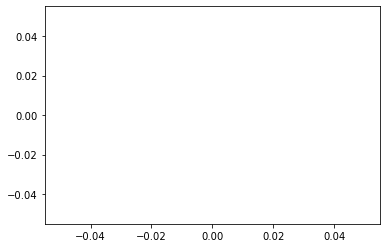

In [10]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.show()


In [58]:
!ls gan_images

'ls' is not recognized as an internal or external command,
operable program or batch file.


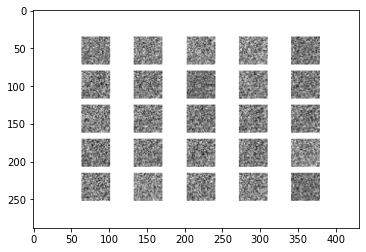

In [11]:
from skimage.io import imread
img = imread('gan_images/0.png')
plt.imshow(img)
plt.show()

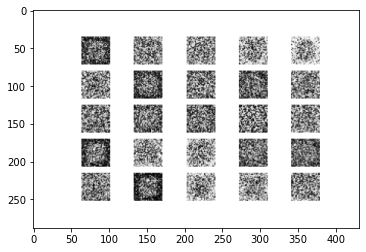

In [12]:
img = imread('GAN_IMAGE/1000.png')
plt.imshow(img)
plt.show()

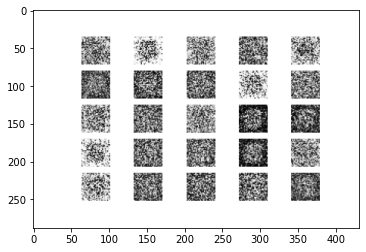

In [13]:
img = imread('GAN_IMAGE/2000.png')
plt.imshow(img)
plt.show()

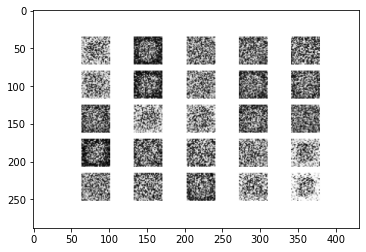

In [14]:
img = imread('GAN_IMAGE/4000.png')
plt.imshow(img)
plt.show()

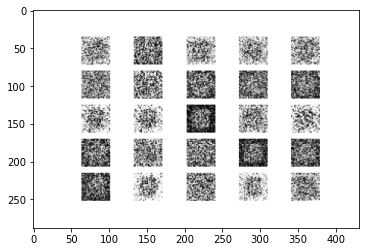

In [15]:
img = imread('GAN_IMAGE/8000.png')
plt.imshow(img)
plt.show()

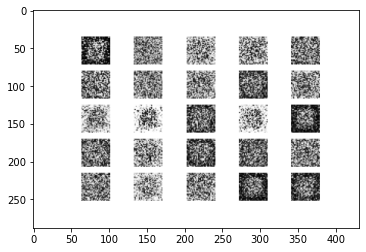

In [16]:
img = imread('GAN_IMAGE/12000.png')
plt.imshow(img)
plt.show()